In [1]:
import copy
import re
import random
from collections import Counter

from notebook import (
    TFIDF,
    MultinomialNB,
    SMOTE,
    Pipeline,
    chi_square,
    split_data,
    accuracy_score,
    cross_validation,
)
from linggapy import Stemmer

from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
pd.set_option('display.max_colwidth', 50)
np.random.seed(42)
random.seed(42)

## Data Collection

In [3]:
dataframes = []

for i in range(4):
    dataframes.append(
        pd.read_excel(
            f"dataset/Klasifikasi Tingkatan Bahasa Bali p{i+1}.xlsx",
            "Sheet1",
            usecols=[1, 2],
        )
    )

df = pd.concat(dataframes, ignore_index=True)

In [4]:
df

,Teks Postingan / Comment,Tingkatan Bahasa/Sor Singgih
0,@gnyrs Kalau kantor Gubernurnya mimin nenten t...,Alus Madia
1,@mangabdiii munyi gen wi besik ne,Basa Andap
2,"Yen di desan nyama patuh masih nyambat ""pang j...",Basa Andap
3,@mangpink84 Nggih pateh taler nganggen ra repa 🙏,Alus Mider
4,"Om swastiastu, nyama sareng sami 🙏🏻\n Kenken k...",NaN
...,...,...
1353,1. Kalimat alus singgih memiliki rasa bahasa y...,NaN
1354,2. Kalimat alus sor merupakan kalimat yang ras...,NaN
1355,3. Kalimat alus madia merupakan kalimat yang m...,NaN
1356,4. Kalimat alus mider merupakan kalimat yang r...,NaN


## Data Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358 entries, 0 to 1357
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Teks Postingan / Comment      1357 non-null   object
 1   Tingkatan Bahasa/Sor Singgih  1340 non-null   object
dtypes: object(2)
memory usage: 21.3+ KB


In [6]:
df = df.dropna()

In [7]:
df = df.rename(columns={"Teks Postingan / Comment": "text", "Tingkatan Bahasa/Sor Singgih": "label"})

In [8]:
df['label'].value_counts().index.tolist()

['Basa Andap',
 'Alus Mider',
 'Alus Singgih',
 'Alus Madia',
 'alus mider',
 'Alus Sor',
 'basa andap',
 'alus madia',
 'Basa Andap ',
 'Alus Mider ',
 'Alus Madya',
 'Basa Kasar',
 'Basa Kamus',
 'Basa Indonesia',
 'Kruna Mider',
 '-',
 'Alus mider',
 'basa kasar',
 'basa madia',
 'Alus sor',
 'alus sor',
 'Bas Andap',
 'Campur Kode',
 'alus singgih ',
 'Akus Madia',
 'pakeh: andap, jinah:alus mider, pragina: basa mider, kraras: mider, biang:alus singgih, peken: andap, godel: mider.',
 'Suksma bli. Tiang demen ajak konten² basa Bali Alus bli ne😁: Basa Andap, ohh.... Nggih Rahajeng Rahina Pagerwesi bli, Dumogi Rahayu sareng sami 🙏🏻🙏🏻: Alus Madia',
 'Alis Singgih',
 'Alus singgih',
 'Alis Sor',
 'Bahasa Pengantar : Alus Singgih. Bahasa isi satua : Basa Andap',
 'Alus Andap',
 'Mider',
 'Basa Kasar Jabag',
 'Basa',
 'Imba Basa Alus',
 'Alus Singggih, Basa Kasar, Basa Andap, Alus Madya, Alus Sor, Alus Singgih',
 'Basa Alus Mider',
 'Basa Sunda',
 'Basa Madia',
 'Alus Singih',
 'Alus SIng

In [9]:
label_mapping = {
    "Basa Andap": "basa andap",
    "Alus Mider": "alus mider",
    "Alus Singgih": "alus singgih",
    "Alus Madia": "alus madia",
    "alus mider": "alus mider",
    "Alus Sor": "alus sor",
    "basa andap": "basa andap",
    "alus madia": "alus madia",
    "Basa Andap ": "basa andap",
    "Alus Mider ": "alus mider",
    "Alus Madya": "alus madia",
    "Basa Kasar": "basa kasar",
    "Kruna Mider": "alus mider",
    "Alus mider": "alus mider",
    "basa kasar": "basa kasar",
    "basa madia": "alus madia",
    "Alus sor": "alus sor",
    "alus sor": "alus sor",
    "Bas Andap": "basa andap",
    "alus singgih ": "alus singgih",
    "Akus Madia": "alus madia",
    "Alis Singgih": "alus singgih",
    "Alus singgih": "alus singgih",
    "Alis Sor": "alus sor",
    "Alus Andap": "basa andap",
    "Mider": "alus mider",
    "Basa Kasar Jabag": "basa kasar",
    "Basa Alus Mider": "alus mider",
    "Basa Madia": "alus madia",
    "Alus Singih": "alus singgih",
    "Alus SInggih": "alus singgih",
    "Basa Mider": "alus mider",
    "Bassa Andap": "basa andap",
    "alus singgih": "alus singgih",
    "alus madia ": "alus madia",
    "basa mider": "alus mider",
    "alus mider ": "alus mider",
}

In [10]:
df['label'] = df['label'].map(label_mapping)
df['label'].value_counts()

label
basa andap      549
alus mider      326
alus madia      181
alus singgih    174
alus sor         72
basa kasar       12
Name: count, dtype: int64

In [11]:
df['label'].value_counts() * 100 / len(df)

label
basa andap      40.970149
alus mider      24.328358
alus madia      13.507463
alus singgih    12.985075
alus sor         5.373134
basa kasar       0.895522
Name: count, dtype: float64

In [12]:
label_to_idx = {
    "alus singgih": 0,
    "alus sor": 1,
    "alus mider": 2,
    "alus madia": 3,
    "basa andap": 4,
    "basa kasar": 5,
}
idx_to_label = {v: k for k, v in label_to_idx.items()}

In [13]:
df["label"] = df["label"].map(
    label_to_idx
)

In [14]:
df

,text,label
0,@gnyrs Kalau kantor Gubernurnya mimin nenten t...,3.0
1,@mangabdiii munyi gen wi besik ne,4.0
2,"Yen di desan nyama patuh masih nyambat ""pang j...",4.0
3,@mangpink84 Nggih pateh taler nganggen ra repa 🙏,2.0
5,Rahajeng semenng 🙏\n \n #basabali #basabaline ...,2.0
...,...,...
1345,Buatin kakak nama komang dimas merta sedana,NaN
1346,"Ngiring mlajah angka Bali, durusang ketik jawa...",3.0
1347,Becik pisan Baligrafi puniki 😍😍\n #Repost @rai...,2.0
1348,#Repost @mlajahbasabali\n • • • • • •\n Ngirin...,2.0


In [15]:
df.dropna()

,text,label
0,@gnyrs Kalau kantor Gubernurnya mimin nenten t...,3.0
1,@mangabdiii munyi gen wi besik ne,4.0
2,"Yen di desan nyama patuh masih nyambat ""pang j...",4.0
3,@mangpink84 Nggih pateh taler nganggen ra repa 🙏,2.0
5,Rahajeng semenng 🙏\n \n #basabali #basabaline ...,2.0
...,...,...
1344,#Repost @mlajahbasabali\n • • • • • •\n wenten...,3.0
1346,"Ngiring mlajah angka Bali, durusang ketik jawa...",3.0
1347,Becik pisan Baligrafi puniki 😍😍\n #Repost @rai...,2.0
1348,#Repost @mlajahbasabali\n • • • • • •\n Ngirin...,2.0


In [16]:
# remove mention and hastag
def clean_text(text: str) -> str:
    cleaned_text = re.sub(r"(@\w+|#\w+)", "", text).strip()
    # keep only alphabet and space
    cleaned_text = re.sub(r"[^a-zA-Z\s]", "", cleaned_text)
    # remove multiple spaces
    cleaned_text = re.sub(r"\s+", " ", cleaned_text)
    cleaned_text = cleaned_text.strip()
    cleaned_text = cleaned_text.lower()
    return cleaned_text


def remove_template(text: str) -> str:
    template_list = [
 """🙏 Elingang like, follow lan share instagram @bahasa_bali mangda iraga prasida mlajah basa lan aksara Bali sareng-sareng.
 .....................
 Ngiring wacén suratan lianan ring belajarbahasabali.com
 facebook: facebook.com/bahasabalii/
 youtube: youtube.com/c/BelajarBahasaBalii""",
 """🙏 Elingang like, follow lan share instagram @bahasa_bali mangda iraga prasida mlajah basa lan aksara Ba🙏 Elingang like, follow lan share instagram @bahasa_bali mangda iraga prasida mlajah basa lan aksara Ba#malajahbahasabalili sareng-sareng.
 .....................
 Ngiring wacén suratan lianan ring belajarbahasabali.com
 facebook: facebook.com/bahasabalii/
 youtube: youtube.com/c/BelajarBahasaBalii
 .....................""",
 """ 🙏 Elingang like, follow lan share instagram @bahasa_bali mangda iraga prasida mlajah basa lan aksara Bali sareng-sareng.
 .....................
 Ngiring wacén sesuratan lianan ring belajarbahasabali.com
 instagram: instagram.com/bahasa_bali
 facebook: facebook.com/bahasabalii
 youtube: youtube.com/c/BelajarBahasaBalii""",
 """🙏elingang like, follow lan share instagram @bahasa_bali mangda iraga prasida mlajah basa lan aksara Bali sareng-sareng.""",
 """🙏elingang like, follow lan share instagram
 @bahasa_bali mangda iraga prasida mlajah basa lan
 aksara Bali sareng-sareng.""",
    ]

    for template in template_list:
        text = text.replace(template, "")

    return text

In [17]:
stemmer = Stemmer()

In [18]:
df['text'] = df['text'].apply(remove_template)
df['text'] = df['text'].apply(clean_text)
ori_df = df.copy()
df['text'] = df['text'].apply(lambda x: stemmer.stem(x, correct_spelling=False))

In [19]:
df = df.dropna()
ori_df = ori_df.dropna()

In [20]:
df

,text,label
0,lau kantor gubernurnya mimi nenten tatas uning...,3.0
1,munyi gen wi besik ne,4.0
2,yen di desa nyama patuh masih ambat pang joh ra,4.0
3,nggih pateh taler kangge ra repa,2.0
5,rahajeng semenng,2.0
...,...,...
1344,wenten sane sampun bani kangge aksara bali rin...,3.0
1346,giring mlajah angka bali durus ketik jawaban r...,3.0
1347,becik pisan baligrafi puniki baligrafi singa raja,2.0
1348,giring malajah aksara bali repost fb made,2.0


## Data Visualization

In [21]:
def get_total_and_unique_words():
    all_string = " ".join(df['text'].values).split()
    total_words = len(all_string)
    unique_words = len(set(all_string))
    return total_words, unique_words

get_total_and_unique_words()

(17874, 4021)

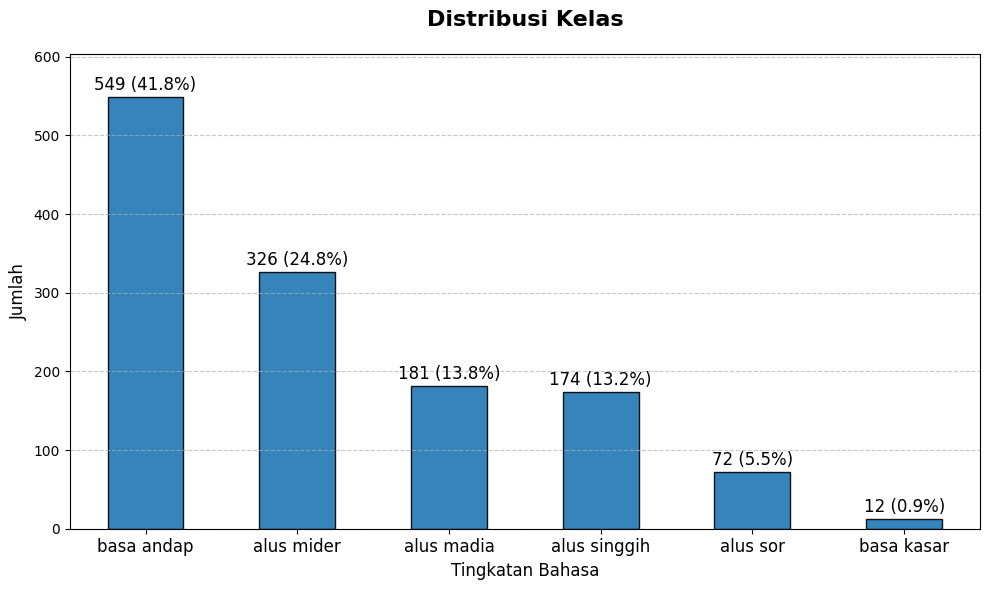

In [22]:
def get_all_class_distribution():
    _, ax = plt.subplots(figsize=(10, 6))

    value_counts = df["label"].value_counts()
    value_counts.plot(kind="bar", ax=ax, alpha=0.9, edgecolor="black")

    mapped_labels = [
        idx_to_label.get(label, str(label)) for label in value_counts.index
    ]
    ax.set_xticks(range(len(mapped_labels)))
    ax.set_xticklabels(mapped_labels, fontsize=12, rotation=0)

    ax.set_title("Distribusi Kelas", fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Tingkatan Bahasa", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)
    ax.set_ylim(0, value_counts.max() * 1.1)

    total = sum(p.get_height() for p in ax.patches)

    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total) * 100
        annotation = f"{count} ({percentage:.1f}%)"
        ax.annotate(
            annotation,
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="baseline",
            fontsize=12,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.savefig("chart/class_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()


get_all_class_distribution()

In [23]:
def get_top_words_by_label():
    top_words = 15

    def get_top_words(group):
        all_words = " ".join(group).lower().split()
        word_counts = Counter(all_words)
        top_10 = [word for word, _ in word_counts.most_common(top_words)]
        return ", ".join(top_10)

    top_words_by_label = ori_df.groupby("label")["text"].apply(get_top_words).reset_index()
    top_words_by_label.columns = ["label", f"top_{top_words}_words"]
    top_words_by_label["label"] = top_words_by_label["label"].map(idx_to_label)
    pd.set_option("display.max_colwidth", None)
    return top_words_by_label


get_top_words_by_label()

,label,top_15_words
0,alus singgih,"sane, ring, bali, becik, pisan, semeton, wenten, sampun, niki, yening, puniki, dados, sareng, napi, sami"
1,alus sor,"sane, ring, titiang, bali, nunas, mbok, sampun, punika, becik, semeton, basa, tityang, suksma, puniki, wenten"
2,alus mider,"sane, ring, bali, aksara, nggih, ngiring, semeton, wenten, rahajeng, saking, kruna, sampun, malajah, puniki, uning"
3,alus madia,"sane, ring, nggih, bali, semeton, becik, pisan, wenten, durus, yening, sampun, dados, ten, tiang, napi"
4,basa andap,"bali, ane, ne, di, aksara, basa, sane, sing, min, ada, yen, ton, coba, i, malajah"
5,basa kasar,"ne, jeg, ningeh, kasar, lengeh, wake, nidik, nyolsol, mantet, nyadeg, nyegseg, ngamah, biase, munyi, kene"


In [24]:
def get_top_words_counter():
    word_freq = Counter()

    for sentence in ori_df["text"]:
        words = sentence.split()
        word_freq.update(words)

    top_words = [word for word, _ in word_freq.most_common(10)]
    result_df = pd.DataFrame(0, index=top_words, columns=idx_to_label.keys())
    for _, row in ori_df.iterrows():
        label = row["label"]
        words = row["text"].split()
        word_counts = Counter(words)
        for word in top_words:
            result_df.at[word, label] += word_counts.get(word, 0)
    result_df.columns = [idx_to_label.get(label) for label in result_df.columns]
    return result_df

get_top_words_counter()

,alus singgih,alus sor,alus mider,alus madia,basa andap,basa kasar
sane,74,35,155,75,51,0
bali,36,23,116,33,98,0
ring,58,34,124,56,33,0
nggih,14,9,66,50,23,0
semeton,32,13,63,29,19,0
aksara,9,1,69,11,64,0
wenten,31,11,63,27,20,0
sampun,30,16,48,26,12,0
basa,13,13,33,10,54,0
ngiring,13,7,66,12,19,0


## Modeling

### Hyperparameter Tuning

In [25]:
CV_HISTORY = []

In [26]:
def smote_resampling(X: np.ndarray, y: np.ndarray):
    """
    Apply SMOTE resampling using not majority
    """
    smote = SMOTE(k_neighbors=5, random_state=42)

    dict_y = Counter(y)
    majority_class = max(dict_y, key=dict_y.get)
    max_count = dict_y[majority_class]

    percentage_increase = {
        cls: np.floor((max_count - count) / count * 100)
        for cls, count in dict_y.items()
        if cls != majority_class
    }

    X_train_sampled, y_train_sampled = X, y
    for cls, pct in percentage_increase.items():
        X_train_sampled, y_train_sampled = smote.fit_resample(
            X_train_sampled, y_train_sampled, int(cls), max_count, N=pct
        )

    return X_train_sampled, y_train_sampled

In [27]:
def find_best_model(X: np.ndarray, y: np.ndarray, options: dict) -> dict:
    global CV_HISTORY
    
    progress_bar = tqdm(
        total=options.get("total"), desc="Searching for best hyperparameters"
    )

    best_score = 0
    best_params = None

    for n_pct_features in options.get("n_pct_features"):
        for alpha in options.get("alpha"):
            for resample in options.get("resample"):
                try:
                    X_train = copy.deepcopy(X)
                    y_train = copy.deepcopy(y)

                    tfidf = TFIDF()
                    X_train_tfidf = tfidf.fit_transform(X_train)

                    feature_score = chi_square(X_train_tfidf, y_train)
                    n_features = int(n_pct_features * X_train_tfidf.shape[1])
                    top_features = np.argsort(feature_score)[::-1][:n_features]

                    if resample:
                        X_train_tfidf, y_train = smote_resampling(
                            X_train_tfidf, y_train
                        )

                    X_train_selected = X_train_tfidf[:, top_features]

                    model = MultinomialNB(alpha=alpha)
                    model.fit(X_train_selected, y_train)

                    cv_score = cross_validation(
                        model, X_train_selected, y_train, k_folds=5, random_state=42
                    )
                    avg_score = np.mean(cv_score)

                    CV_HISTORY.append(
                        {
                            "avg_score": avg_score,
                            "n_pct_features": n_pct_features,
                            "n_features": n_features,
                            "alpha": alpha,
                            "resample": resample,
                        }
                    )

                    if avg_score > best_score:
                        best_score = avg_score
                        best_params = {
                            "best_score": best_score,
                            "n_pct_features": n_pct_features,
                            "n_features": n_features,
                            "alpha": alpha,
                            "resample": resample,
                        }
                    progress_bar.update(1)
                except Exception as e:
                    print(e)
    progress_bar.close()
    return best_params

In [28]:
X = df['text'].astype(str)
y = df['label']

In [29]:
N_PCT_FEATURES_OPTIONS = np.arange(40, 101, 10) / 100 
ALPHA_OPTIONS = np.arange(0.25, 1.1, 0.25)
RESAMPLE_OPTIONS = np.arange(2)

In [30]:
N_PCT_FEATURES_OPTIONS, ALPHA_OPTIONS, RESAMPLE_OPTIONS

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.25, 0.5 , 0.75, 1.  ]),
 array([0, 1]))

In [31]:
options = {
    "n_pct_features": N_PCT_FEATURES_OPTIONS,
    "alpha": ALPHA_OPTIONS,
    "resample": RESAMPLE_OPTIONS,
    "total": len(N_PCT_FEATURES_OPTIONS) * len(ALPHA_OPTIONS) * len(RESAMPLE_OPTIONS),
}

In [32]:
X_train, X_test, y_train, y_test = split_data(
    X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=42
)

In [33]:
Counter(y_train)

Counter({np.float64(4.0): 442,
         np.float64(2.0): 260,
         np.float64(3.0): 144,
         np.float64(0.0): 140,
         np.float64(1.0): 57,
         np.float64(5.0): 9})

In [34]:
BEST_MODEL_CONFIG = find_best_model(X_train, y_train, options)
BEST_MODEL_CONFIG

Searching for best hyperparameters: 100%|██████████| 56/56 [12:56<00:00, 13.87s/it]


{'best_score': np.float64(0.9121393105405022),
 'n_pct_features': np.float64(0.7),
 'n_features': 2370,
 'alpha': np.float64(0.25),
 'resample': np.int64(1)}

In [35]:
df_history = pd.DataFrame(CV_HISTORY)

In [36]:
df_history.head()

,avg_score,n_pct_features,n_features,alpha,resample
0,0.653064,0.4,1354,0.25,0
1,0.889137,0.4,1354,0.25,1
2,0.623630,0.4,1354,0.50,0
3,0.872182,0.4,1354,0.50,1
4,0.608410,0.4,1354,0.75,0


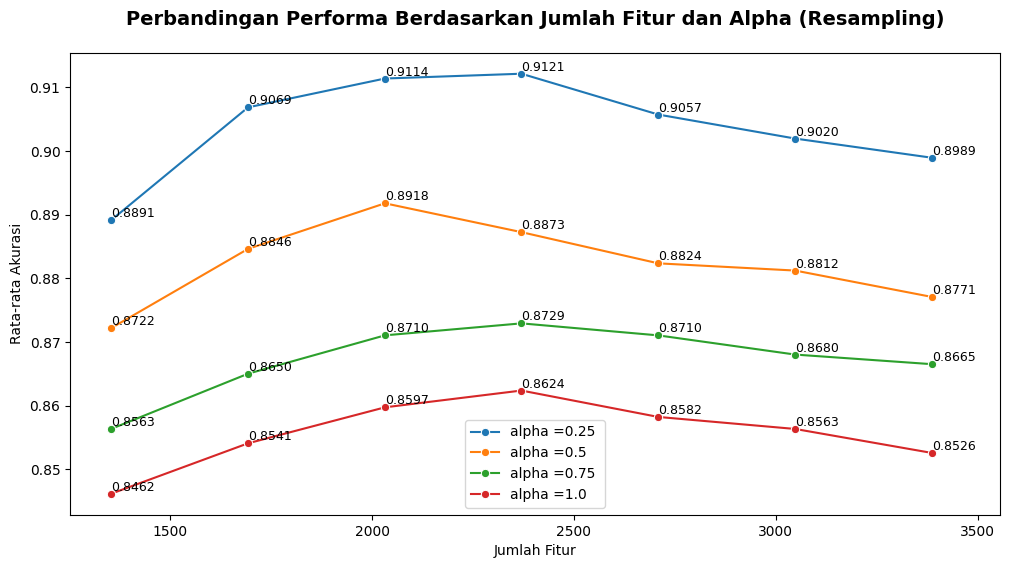

In [37]:
def get_resampling_comparison():
    used_df = df_history[(df_history["resample"]  == 1)]
    used_df = used_df[["avg_score", "n_features", "alpha"]]
    plt.figure(figsize=(12, 6))
    for alpha in ALPHA_OPTIONS:
        if alpha == 0:
            continue
        used_data = used_df[used_df["alpha"] == alpha]

        sns.lineplot(
            x="n_features",
            y="avg_score",
            data=used_data,
            label=f"alpha ={alpha} ",
            marker="o",
        )

        for i in range(used_data.shape[0]):
            plt.text(
                used_data["n_features"].iloc[i],
                used_data["avg_score"].iloc[i],
                f"{used_data['avg_score'].iloc[i]:.4f}",
                horizontalalignment="left",
                verticalalignment="bottom",
                fontsize=9,
            )

    plt.title(
        "Perbandingan Performa Berdasarkan Jumlah Fitur dan Alpha (Resampling)",
        fontsize=14,
        weight="bold",
        pad=20,
    )
    plt.xlabel("Jumlah Fitur")
    plt.ylabel("Rata-rata Akurasi")

    # padding
    x_min, x_max = plt.xlim()
    plt.xlim(x_min, x_max + 0.03 * (x_max - x_min))

    plt.legend()
    plt.savefig("chart/cv_performance_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()

get_resampling_comparison()

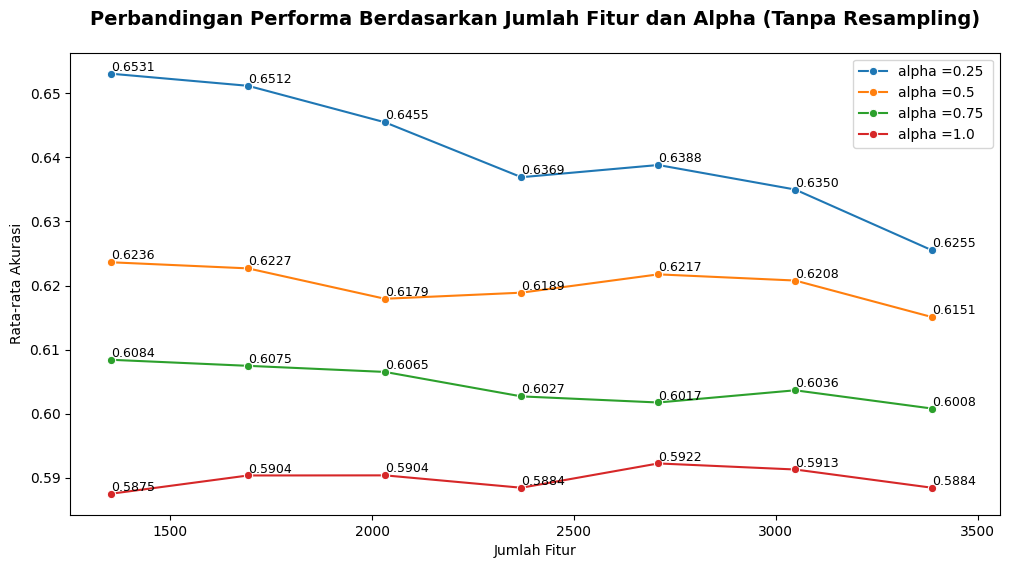

In [38]:
def get_no_resampling_comparison():
    used_df = df_history[(df_history["resample"] == 0)]
    used_df = used_df[["avg_score", "n_features", "alpha"]]

    plt.figure(figsize=(12, 6))
    for alpha in ALPHA_OPTIONS:
        if alpha == 0:
            continue
        used_data = used_df[used_df["alpha"] == alpha]

        sns.lineplot(
            x="n_features",
            y="avg_score",
            data=used_data,
            label=f"alpha ={alpha} ",
            marker="o",
        )

        for i in range(used_data.shape[0]):
            plt.text(
                used_data["n_features"].iloc[i],
                used_data["avg_score"].iloc[i],
                f"{used_data['avg_score'].iloc[i]:.4f}",
                horizontalalignment="left",
                verticalalignment="bottom",
                fontsize=9,
            )

    plt.title(
        "Perbandingan Performa Berdasarkan Jumlah Fitur dan Alpha (Tanpa Resampling)",
        fontsize=14,
        weight="bold",
        pad=20,
    )
    plt.xlabel("Jumlah Fitur")
    plt.ylabel("Rata-rata Akurasi")

    # padding
    x_min, x_max = plt.xlim()
    plt.xlim(x_min, x_max + 0.03 * (x_max - x_min))

    plt.legend()
    plt.savefig(
        "chart/cv_performance_comparison_no_resample.png", dpi=300, bbox_inches="tight"
    )
    plt.show()


get_no_resampling_comparison()

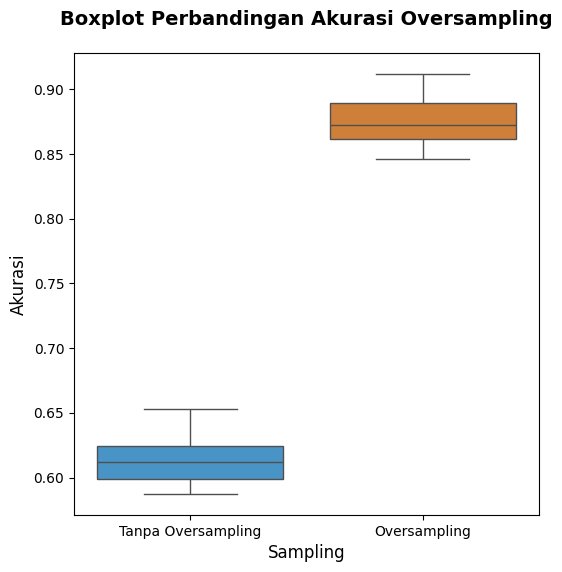

In [40]:
def get_boxplot_oversampling_comparison():
    plt.figure(figsize=(6, 6))
    used_df = df_history.copy()
    used_df["resample"] = used_df["resample"].astype("category")
    used_df["resample"] = used_df["resample"].map({0: "Tanpa Oversampling", 1: "Oversampling"})

    sns.boxplot(
        data=used_df,
        x="resample",
        y="avg_score",
        hue="resample",
        legend=False,
        palette=["#3498db", "#e67e22"],
    )

    plt.title(
        "Boxplot Perbandingan Akurasi Oversampling",
        fontsize=14,
        weight="bold",
        pad=20,
    )
    plt.xlabel("Sampling", fontsize=12)
    plt.ylabel("Akurasi", fontsize=12)
    plt.savefig(
        "chart/boxplot_oversampling_comparsion.png", dpi=300, bbox_inches="tight"
    )
    plt.show()


get_boxplot_oversampling_comparison()

### Best Model

In [41]:
X_train, X_test, y_train, y_test = split_data(
    X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=42
)

In [42]:
tfidf = TFIDF()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [43]:
feature_score = chi_square(X_train_tfidf, y_train)
feature_score

array([7.564816  , 0.89543383, 3.46582559, ..., 1.12791769, 3.90949227,
       3.49051906])

In [44]:
n_pct_features = BEST_MODEL_CONFIG.get("n_pct_features")
n_features = int(n_pct_features * X_train_tfidf.shape[1])
top_features = np.argsort(feature_score)[::-1][:n_features]
n_features

2370

In [45]:
mapped_labels = [idx_to_label.get(label, str(label)) for label in y_train]
value_counts = Counter(mapped_labels)
value_counts

Counter({'basa andap': 442,
         'alus mider': 260,
         'alus madia': 144,
         'alus singgih': 140,
         'alus sor': 57,
         'basa kasar': 9})

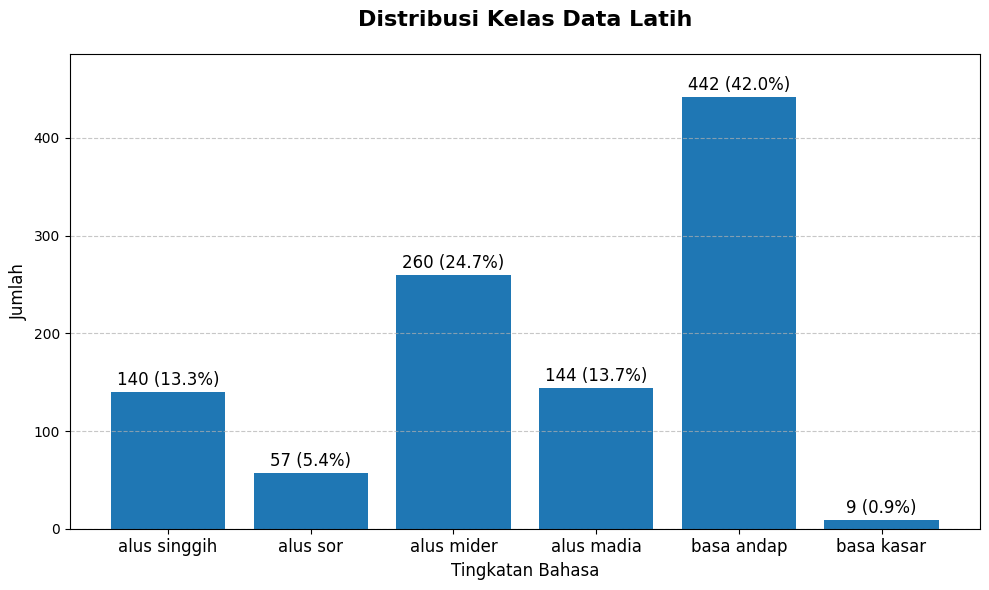

In [48]:
def get_training_data_distribution():

    _, ax = plt.subplots(figsize=(10, 6))

    mapped_labels = [idx_to_label.get(label, str(label)) for label in y_train]
    value_counts = Counter(mapped_labels)
    ordered_value_counts = Counter(
        {key: value_counts[key] for key in label_to_idx.keys()}
    )

    unique_labels = list(ordered_value_counts.keys())
    counts = list(ordered_value_counts.values())
    ax.bar(unique_labels, counts)
    ax.set_xticks(range(len(unique_labels)))
    ax.set_xticklabels(unique_labels, fontsize=12, rotation=0)
    ax.set_title("Distribusi Kelas Data Latih", fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Tingkatan Bahasa", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)

    ax.set_ylim(0, max(counts) * 1.1)

    total = sum(counts)
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total) * 100
        annotation = f"{count} ({percentage:.1f}%)"
        ax.annotate(
            annotation,
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="baseline",
            fontsize=12,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.savefig(
        "chart/train_data_distribution.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

get_training_data_distribution()

In [47]:
resample = BEST_MODEL_CONFIG.get("resample")
if resample:
    X_train_sampled, y_train_sampled = smote_resampling(X_train_tfidf, y_train)
else:
    X_train_sampled, y_train_sampled = X_train_tfidf, y_train

In [49]:
Counter(y_train_sampled)

Counter({np.float64(2.0): 442,
         np.float64(4.0): 442,
         np.float64(1.0): 442,
         np.float64(3.0): 442,
         np.float64(0.0): 442,
         np.float64(5.0): 442})

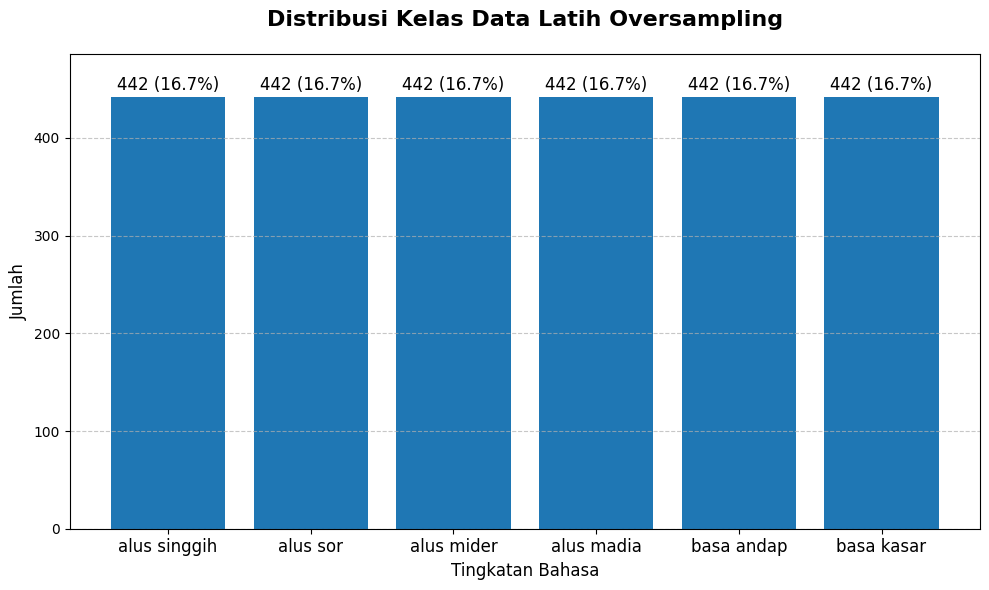

In [50]:
def get_training_data_distribution_resampled():
    _, ax = plt.subplots(figsize=(10, 6))

    mapped_labels = [idx_to_label.get(label, str(label)) for label in y_train_sampled]
    value_counts = Counter(mapped_labels)
    ordered_value_counts = Counter({key: value_counts[key] for key in label_to_idx.keys()})

    unique_labels = list(ordered_value_counts.keys())
    counts = list(ordered_value_counts.values())
    ax.bar(unique_labels, counts)
    ax.set_xticks(range(len(unique_labels)))
    ax.set_xticklabels(unique_labels, fontsize=12, rotation=0)
    ax.set_title("Distribusi Kelas Data Latih Oversampling", fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Tingkatan Bahasa", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)

    ax.set_ylim(0, max(counts) * 1.1)

    total = sum(counts)
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total) * 100
        annotation = f"{count} ({percentage:.1f}%)"
        ax.annotate(
            annotation,
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="baseline",
            fontsize=12,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(
        "chart/resampled_train_data_distribution.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

if resample:
    get_training_data_distribution_resampled()

In [51]:
X_train_selected = X_train_sampled[:, top_features]
X_test_selected = X_test_tfidf[:, top_features]

In [52]:
mnb = MultinomialNB(alpha=BEST_MODEL_CONFIG.get("alpha"))
mnb.fit(X_train_selected, y_train_sampled)

In [53]:
y_train_pred = mnb.predict(X_train_selected)
train_report = classification_report(
    y_train_sampled,
    y_train_pred,
    digits=4,
    zero_division=0,
    output_dict=True,
    target_names=idx_to_label.values(),
)

In [54]:
print(
    classification_report(
        y_train_sampled,
        y_train_pred,
        digits=4,
        zero_division=0,
        target_names=idx_to_label.values(),
    )
)

              precision    recall  f1-score   support

alus singgih     0.9659    0.9615    0.9637       442
    alus sor     0.9690    0.9910    0.9799       442
  alus mider     0.9284    0.9389    0.9336       442
  alus madia     0.9471    0.9729    0.9598       442
  basa andap     0.9927    0.9208    0.9554       442
  basa kasar     0.9844    1.0000    0.9921       442

    accuracy                         0.9642      2652
   macro avg     0.9646    0.9642    0.9641      2652
weighted avg     0.9646    0.9642    0.9641      2652



<Figure size 1200x800 with 0 Axes>

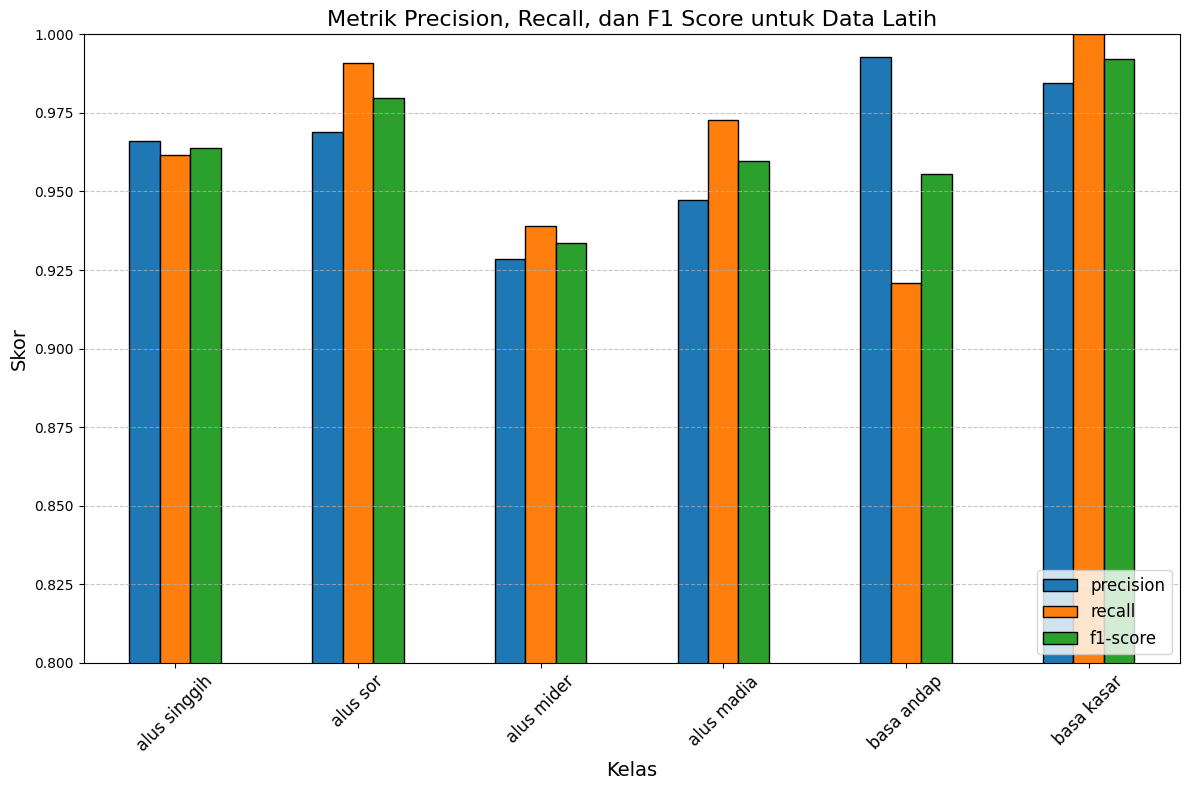

In [55]:
def get_train_report():
    report_df = pd.DataFrame(train_report).transpose()

    class_metrics = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

    plt.figure(figsize=(12, 8))
    class_metrics[['precision', 'recall', 'f1-score']].plot(
        kind='bar', figsize=(12, 8), edgecolor='black'
    )

    plt.title('Metrik Precision, Recall, dan F1 Score untuk Data Latih', fontsize=16)
    plt.xlabel('Kelas', fontsize=14)
    plt.ylabel('Skor', fontsize=14)
    plt.xticks(ticks=range(len(class_metrics)), labels=class_metrics.index, rotation=45, fontsize=12)
    plt.ylim(0.8, 1)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(
        "chart/train_report.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

get_train_report()

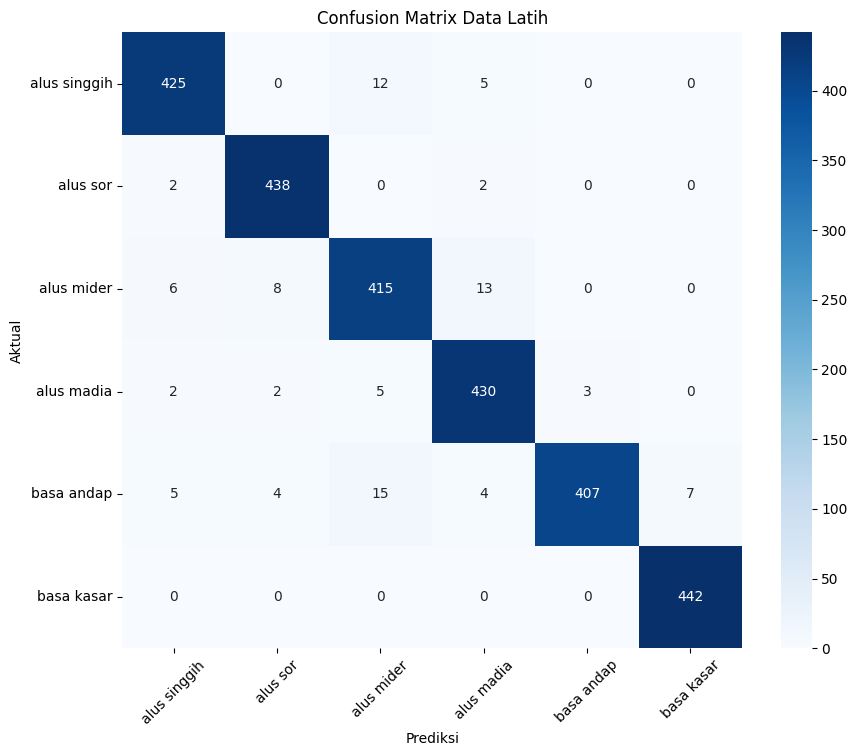

In [56]:
def get_training_cm():    
    cm = confusion_matrix(y_train_sampled, y_train_pred)

    labels = [idx_to_label[i] for i in range(len(idx_to_label))]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.title("Confusion Matrix Data Latih")
    plt.ylabel("Aktual")
    plt.xlabel("Prediksi")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.savefig(
        "chart/train_cm.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

get_training_cm()

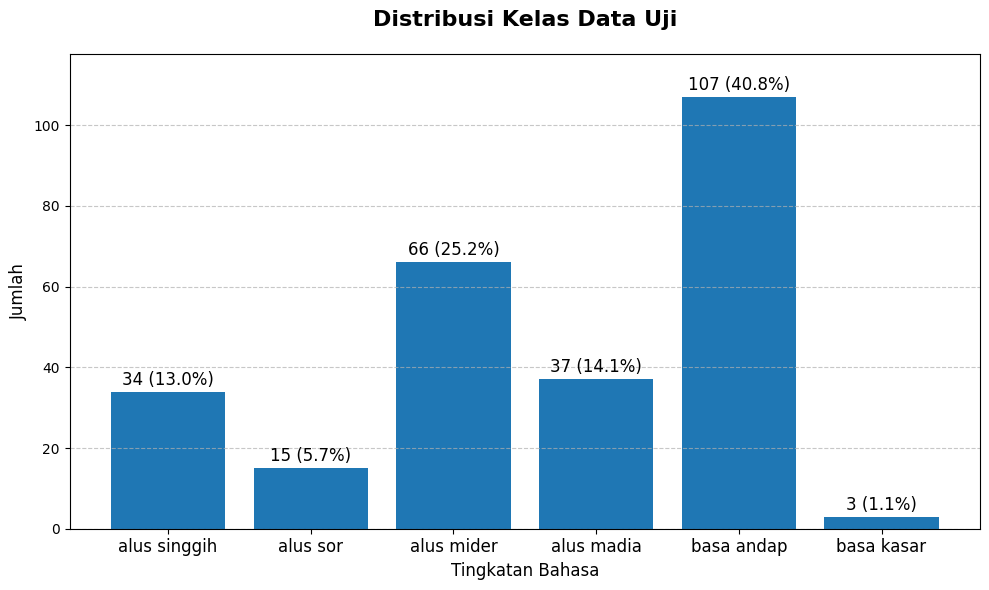

In [59]:
def get_test_data_distribution():
    _, ax = plt.subplots(figsize=(10, 6))


    mapped_labels = [idx_to_label.get(label, str(label)) for label in y_test]
    value_counts = Counter(mapped_labels)

    ordered_value_counts = Counter({key: value_counts[key] for key in label_to_idx.keys()})

    unique_labels = list(ordered_value_counts.keys())
    counts = list(ordered_value_counts.values())
    ax.bar(unique_labels, counts)
    ax.set_xticks(range(len(unique_labels)))
    ax.set_xticklabels(unique_labels, fontsize=12, rotation=0)
    ax.set_title("Distribusi Kelas Data Uji", fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Tingkatan Bahasa", fontsize=12)
    ax.set_ylabel("Jumlah", fontsize=12)

    ax.set_ylim(0, max(counts) * 1.1)

    total = sum(counts)
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total) * 100
        annotation = f"{count} ({percentage:.1f}%)"
        ax.annotate(
            annotation,
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="baseline",
            fontsize=12,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    plt.savefig(
        "chart/test_data_distribution.png", dpi=300, bbox_inches="tight"
    )
    plt.tight_layout()
    plt.show()

get_test_data_distribution()

In [60]:
y_test_pred = mnb.predict(X_test_selected)
test_report = classification_report(
    y_test,
    y_test_pred,
    digits=4,
    zero_division=0,
    target_names=idx_to_label.values(),
    output_dict=True
)

In [61]:
print(classification_report(
    y_test,
    y_test_pred,
    digits=4,
    zero_division=0,
    target_names=idx_to_label.values(),
))

              precision    recall  f1-score   support

alus singgih     0.3889    0.4118    0.4000        34
    alus sor     0.3182    0.4667    0.3784        15
  alus mider     0.5625    0.5455    0.5538        66
  alus madia     0.3673    0.4865    0.4186        37
  basa andap     0.9545    0.7850    0.8615       107
  basa kasar     0.3333    0.3333    0.3333         3

    accuracy                         0.6107       262
   macro avg     0.4875    0.5048    0.4910       262
weighted avg     0.6559    0.6107    0.6279       262



<Figure size 1200x800 with 0 Axes>

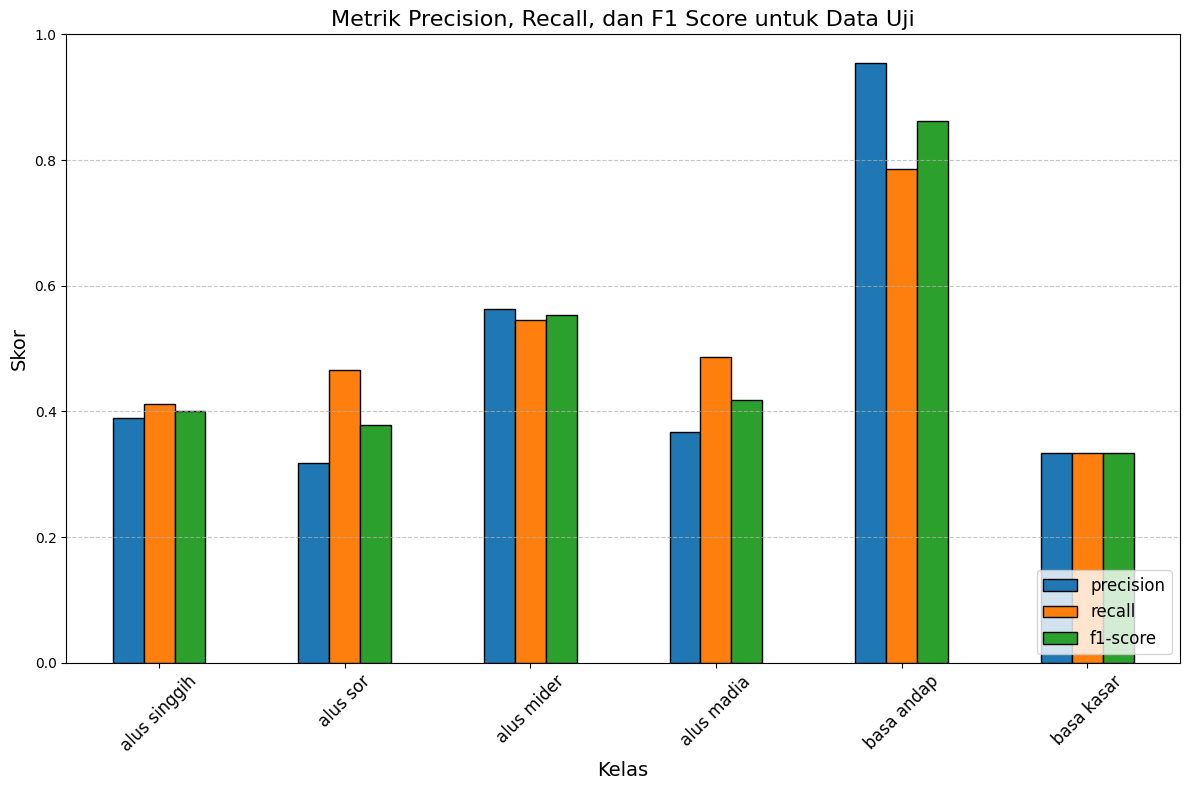

In [62]:
def get_test_report():    
    report_df = pd.DataFrame(test_report).transpose()

    class_metrics = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

    plt.figure(figsize=(12, 8))
    class_metrics[['precision', 'recall', 'f1-score']].plot(
        kind='bar', figsize=(12, 8), edgecolor='black'
    )

    plt.title('Metrik Precision, Recall, dan F1 Score untuk Data Uji', fontsize=16)
    plt.xlabel('Kelas', fontsize=14)
    plt.ylabel('Skor', fontsize=14)
    plt.xticks(ticks=range(len(class_metrics)), labels=class_metrics.index, rotation=45, fontsize=12)
    plt.ylim(0, 1)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(
        "chart/test_report.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

get_test_report()

In [63]:
accuracy_score(y_test, y_test_pred)

0.6106870229007634

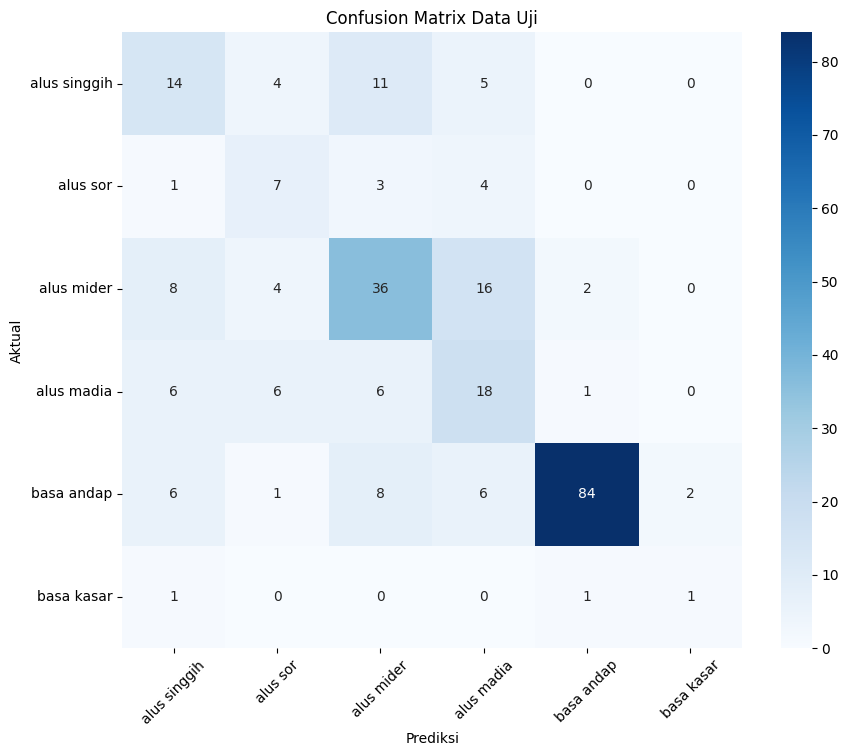

In [64]:
def get_test_cm():
    cm = confusion_matrix(y_test, y_test_pred)

    labels = [idx_to_label[i] for i in range(len(idx_to_label))]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.title("Confusion Matrix Data Uji")
    plt.ylabel("Aktual")
    plt.xlabel("Prediksi")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.savefig(
        "chart/test_cm.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

get_test_cm()

## Inference

In [42]:
pipeline = Pipeline(mnb, tfidf, top_features)

In [43]:
text = "mai be medaar malu"
text = stemmer.stem(text, correct_spelling=False)
idx_to_label[pipeline.predict(text)]

'basa andap'

In [44]:
pipeline.predict_proba(text)

array([[0.01337959, 0.0100574 , 0.014754  , 0.01433398, 0.93131224,
        0.01616279]])

In [45]:
pipeline.save("model/pipeline.joblib")

In [46]:
loaded_pipeline = joblib.load("model/pipeline.joblib")

In [47]:
text = "jeleme cicing sing ade ape"
text = stemmer.stem(text, correct_spelling=False)
idx_to_label[loaded_pipeline.predict(text)]

'basa kasar'

In [48]:
loaded_pipeline.predict_proba(text)

array([[0.00158792, 0.00115469, 0.00176267, 0.00225459, 0.09018504,
        0.90305511]])